In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_pickle("../data/depresjon/depresjon_preprocessed.pkl")
df

,user_id,activity,days,gender,age,afftype,melanch,inpatient,edu,marriage,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,1,346.550000,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,2,2
1,1,284.566667,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,2,2
2,1,279.183333,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,2,2
3,1,218.783333,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,1
4,1,238.550000,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9209,9,0.000000,13,2,2,1.0,2.0,2.0,1,1.0,...,-0.781831,0.433884,-0.24869,0.897805,0.623490,-0.900969,0.968583,-0.440394,0,0
9210,9,14.600000,13,2,2,1.0,2.0,2.0,1,1.0,...,-0.781831,0.433884,-0.24869,0.897805,0.623490,-0.900969,0.968583,-0.440394,1,0
9211,9,511.316667,13,2,2,1.0,2.0,2.0,1,1.0,...,-0.781831,0.433884,-0.24869,0.897805,0.623490,-0.900969,0.968583,-0.440394,2,2
9212,9,7.733333,13,2,2,1.0,2.0,2.0,1,1.0,...,-0.781831,0.433884,-0.24869,0.897805,0.623490,-0.900969,0.968583,-0.440394,0,0


In [3]:
# This approach is particularly useful for time-series or user-based data to avoid leakage.

def split_dataframe(df, target_column, test_size=0.3, val_size=0.2):
    """
    Splits the dataframe into training, validation, and testing sets.
    
    Parameters:
    - df: DataFrame, the dataset to split.
    - target_column: str, the name of the target column.
    - test_size: float, proportion of the dataset to include in the test split.
    - val_size: float, proportion of the training dataset to include in the validation split.
    
    Returns:
    - X_train, y_train: Training features and labels.
    - X_val, y_val: Validation features and labels.
    - X_test, y_test: Testing features and labels.
    """
    # Splitting the dataframe into train and test set such that each 'user_id' belongs to either set
    unique_ids = df['user_id'].unique()
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=42)

    train_df = df[df['user_id'].isin(train_ids)]
    test_df = df[df['user_id'].isin(test_ids)]

    # Further splitting the training data into training and validation sets
    train_ids, val_ids = train_test_split(train_df['user_id'].unique(), test_size=val_size, random_state=42)
    val_df = train_df[train_df['user_id'].isin(val_ids)]
    train_df = train_df[~train_df['user_id'].isin(val_ids)]

    # Dropping the 'user_id' column
    train_df = train_df.drop(columns=['user_id'])
    val_df = val_df.drop(columns=['user_id'])
    test_df = test_df.drop(columns=['user_id'])

    # Separating features and target variable for each set
    X_train = train_df.drop(columns=[target_column])
    y_train = train_df[target_column]

    X_val = val_df.drop(columns=[target_column])
    y_val = val_df[target_column]

    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataframe(df, target_column='category_madrs', test_size=0.3)
print(X_train.shape, X_val.shape, X_test.shape)

(5086, 21) (1268, 21) (2496, 21)


In [5]:
# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [10, 20, 30, None],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}

#clf = RandomForestClassifier(random_state=42)

# Grid search for MCC
#mcc_scorer = make_scorer(matthews_corrcoef)
#grid_search_mcc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, scoring=mcc_scorer, n_jobs=-1)
#grid_search_mcc.fit(X_train, y_train)

# Grid search for accuracy
#grid_search_acc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
#grid_search_acc.fit(X_train, y_train)

# Get the best parameters and scores
#best_params_mcc = grid_search_mcc.best_params_
#best_score_mcc = grid_search_mcc.best_score_

#best_params_acc = grid_search_acc.best_params_
#best_score_acc = grid_search_acc.best_score_

#print("Best parameters for MCC:", best_params_mcc)
#print("Best MCC score:", best_score_mcc)
#print("Best parameters for accuracy:", best_params_acc)
#print("Best accuracy score:", best_score_acc)

Best parameters for MCC: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MCC score: 0.9700219847772992
Best parameters for accuracy: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy score: 0.9838753805065936

In [6]:
# the best parameters
clf_best = RandomForestClassifier(
    max_depth=5,
    min_samples_leaf=10,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)


clf_best.fit(X_train, y_train)
y_pred = clf_best.predict(X_test)
mcc_score = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("MCC on test set:", mcc_score)
print("Accuracy on test set:", accuracy)

MCC on test set: -0.10552935115038604
Accuracy on test set: 0.421875


Classification Report:
 
              precision    recall  f1-score   support

           0       0.49      0.24      0.32      1426
           1       0.40      0.66      0.50      1070

    accuracy                           0.42      2496
   macro avg       0.44      0.45      0.41      2496
weighted avg       0.45      0.42      0.40      2496

----------------------------------------------------------------------------------------


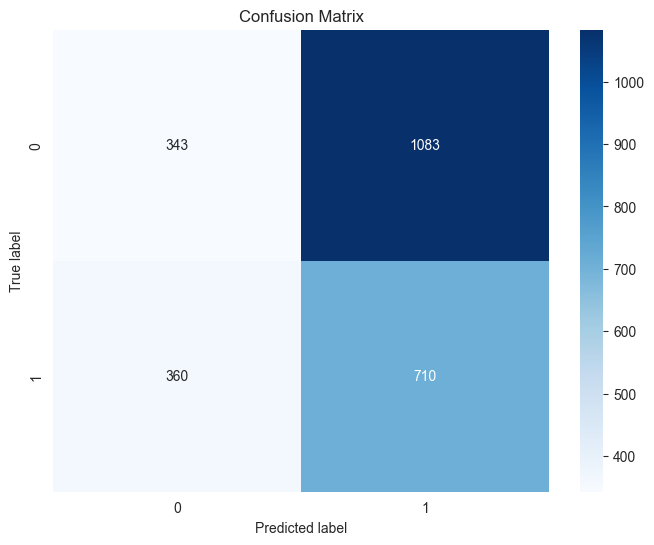

In [7]:
print("Classification Report:")
print(" ")
print(classification_report(y_test, y_pred))
print("----------------------------------------------------------------------------------------")
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [8]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15], 
    'min_samples_split': [4, 6, 8],
    'min_samples_leaf': [2, 3, 4]  
}

clf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=81, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=81, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [4, 6, 8],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, scoring='roc_auc')

In [9]:
y_pred = random_search.predict(X_test)
mcc_score = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("MCC on test set:", mcc_score)
print("Accuracy on test set:", accuracy)

MCC on test set: -0.10552935115038604
Accuracy on test set: 0.421875


Classification Report:
 
              precision    recall  f1-score   support

           0       0.49      0.24      0.32      1426
           1       0.40      0.66      0.50      1070

    accuracy                           0.42      2496
   macro avg       0.44      0.45      0.41      2496
weighted avg       0.45      0.42      0.40      2496

----------------------------------------------------------------------------------------


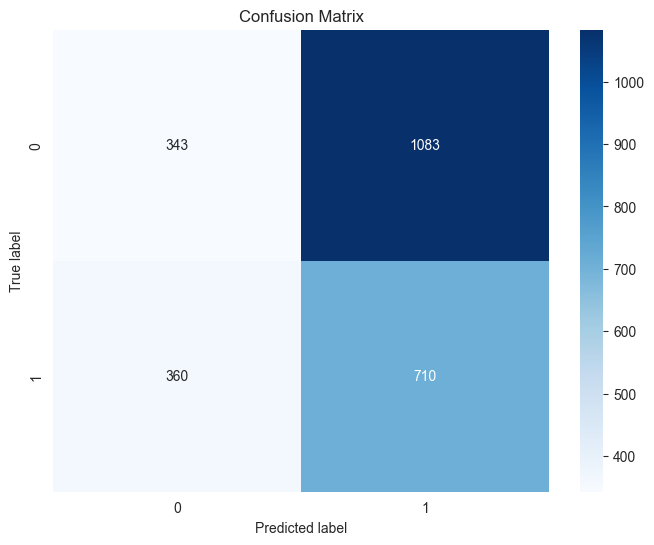

In [10]:
print("Classification Report:")
print(" ")
print(classification_report(y_test, y_pred))
print("----------------------------------------------------------------------------------------")
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

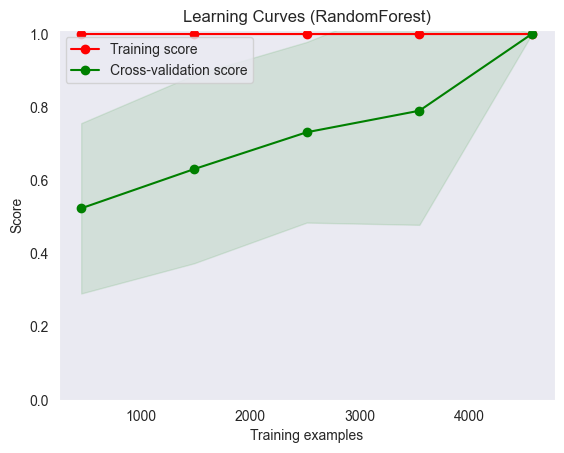

In [11]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
    title : string, title of the chart
    X : array-like, shape (n_samples, n_features), training vector
    y : array-like, shape (n_samples) or (n_samples, n_features), target relative to X
    ylim : tuple, shape (ymin, ymax), Defines minimum and maximum yvalues plotted
    cv : int, cross-validation generator or an iterable, optional
    n_jobs : int or None, optional (default=None)
    train_sizes : array-like, shape (n_ticks,), Relative or absolute numbers of training examples that will be used to generate the learning curve.
    """
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (RandomForest)"
cv = 10 
estimator = RandomForestClassifier(
    max_depth=5,
    min_samples_leaf=10,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
) 
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0, 1.01), cv=cv, n_jobs=4)
plt.show()